# Import Dependencies

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, precision_score, recall_score

# Load Data

In [2]:
# File path to data
path = "Data/telcoChurn.csv"

# Load data
telco = pd.read_csv(path)

# Look at the first few rows of the data
telco.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Get dimensions of data
telco.shape

(7043, 21)

In [4]:
# Get the column types of the data
telco.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

It looks like the SeniorCitizen variable is mistakenly marked as continuous. Let's make it a string to indicate that it is a factor variable.

In [5]:
# Convert Senior Citizen variable to a string
telco["SeniorCitizen"] = telco["SeniorCitizen"].astype(str)

It also looks like TotalCharges is a string when it should be a float.

In [6]:
# Convert TotalCharges to float
telco["TotalCharges"] = pd.to_numeric(telco["TotalCharges"], errors = "coerce")

# Initial Data Exploration

Let's check for missing values and look at the counts for each value of each variable

In [7]:
# Remove customer id column
telco = telco.drop("customerID", axis = 1)
telco.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [8]:
# Look at summary of continous variables
telco.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


In [9]:
# Look at value counts for each categorical variable
catvars = telco.select_dtypes("object").columns
for var in catvars:
    print(telco[var].value_counts())
    print("----------------------")

Male      3555
Female    3488
Name: gender, dtype: int64
----------------------
0    5901
1    1142
Name: SeniorCitizen, dtype: int64
----------------------
No     3641
Yes    3402
Name: Partner, dtype: int64
----------------------
No     4933
Yes    2110
Name: Dependents, dtype: int64
----------------------
Yes    6361
No      682
Name: PhoneService, dtype: int64
----------------------
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64
----------------------
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64
----------------------
No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64
----------------------
No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64
----------------------
No                     3095
Yes                    2422
No internet service  

In [10]:
# Check for missing values
telco.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Looks like the only variable with missing values is TotalCharges

# Split the Data

In [11]:
# Define functionn to split into train/validation/test
def split_data(x, y, train_prop = 0.7, val_prop = 0.2, test_prop = 0.1, random_state = 1986):
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = train_prop, test_size = 1-train_prop, stratify = y, random_state = 1986)
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = test_prop/(test_prop + val_prop), stratify = y_test, random_state = 1986)
    return x_train, x_val, x_test, y_train, y_val, y_test

In [12]:
# Split the data
x_train, x_val, x_test, y_train, y_val, y_test = split_data(telco.drop("Churn", axis = 1), telco["Churn"])

In [13]:
# Put predictors and target back together
train = pd.concat([x_train, y_train], axis = 1).reset_index(drop = True)
val = pd.concat([x_val, y_val], axis = 1).reset_index(drop = True)
test = pd.concat([x_test, y_test], axis = 1).reset_index(drop = True)

# Bivariate Exploration

Before we begin modeling, let's explore bivariate relationships with the Churn variable. Also, check for partial or complete separation.

In [14]:
# Look at crosstabs for categorical variables and churn
for var in catvars:
    print(pd.crosstab(train[var], train["Churn"]).apply(lambda r: r/r.sum(), axis=1))
    print("-------------------------")
    print("")

Churn         No       Yes
gender                    
Female  0.727385  0.272615
Male    0.741730  0.258270
-------------------------

Churn                No       Yes
SeniorCitizen                    
0              0.767250  0.232750
1              0.570025  0.429975
-------------------------

Churn          No       Yes
Partner                    
No       0.675570  0.324430
Yes      0.797819  0.202181
-------------------------

Churn             No       Yes
Dependents                    
No          0.688169  0.311831
Yes         0.843856  0.156144
-------------------------

Churn               No       Yes
PhoneService                    
No            0.754310  0.245690
Yes           0.732647  0.267353
-------------------------

Churn                  No      Yes
MultipleLines                     
No                0.74477  0.25523
No phone service  0.75431  0.24569
Yes               0.71869  0.28131
-------------------------

Churn                  No       Yes
InternetService

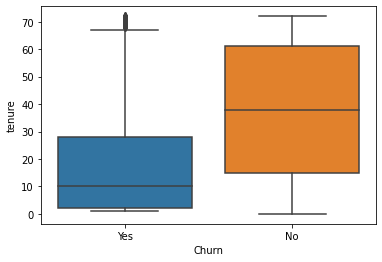

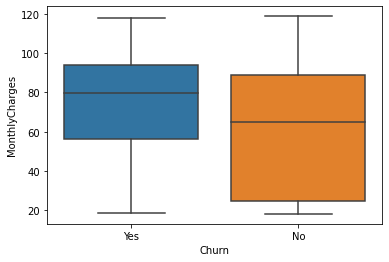

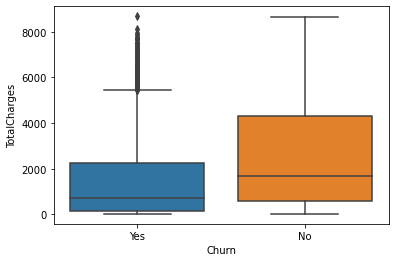

In [15]:
# Look at boxplots of continuous vars vs churn
contVars = ["tenure", "MonthlyCharges", "TotalCharges"]
for var in contVars:
    plt.figure()
    sns.boxplot(x = "Churn", y = var, data = train)

# Build Gradient Boosted Classifier

First we need to convert are data to a DMatrix type

In [16]:
# Instantiate LabelEncoder
lbl = LabelEncoder()

# Label encode categorical variables
for var in catvars.drop("Churn"):
    x_train[var] = lbl.fit_transform(x_train[var])
    x_val[var] = lbl.fit_transform(x_val[var])
    x_test[var] = lbl.fit_transform(x_test[var])

# Label encode target
#y_train = lbl.fit_transform(y_train)
#y_test = lbl.fit_transform(y_test)

# Conver to DMatrix
#D_train = xgb.DMatrix(x_train, label = y_train)
#D_test = xgb.DMatrix(x_test, label = y_test)

Next, we'll conduct a grid search for hyperparameter tuning

In [17]:
# Instantiate Gradient Boosted Classifier
clf = xgb.XGBClassifier(random_state = 1986, nthreads = 1)

# Instantiate K-Fold Stratifier
#skf = StratifiedKFold(n_splits = 3, random_state = 1986)

# Set up hyperparameter grid
parameters = {
    "eta" : [0.05, 0.1, 0.2],
    "max_depth" : [3, 5, 7],
    "subsample" : [0.33, .66, 1],
    "colsample_bytree" : [0.33, 0.66, 1]
}

# Conduct Cross-Validation Hyperparameter tuning
grid = GridSearchCV(estimator = clf,
                    param_grid = parameters,
                    n_jobs = 4,
                    scoring = "neg_log_loss",
                    cv = 3)
grid.fit(X = x_train, y = y_train)

GridSearchCV(cv=3, estimator=XGBClassifier(nthreads=1, random_state=1986),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.33, 0.66, 1],
                         'eta': [0.05, 0.1, 0.2], 'max_depth': [3, 5, 7],
                         'subsample': [0.33, 0.66, 1]},
             scoring='neg_log_loss')

# Find Best Classification Threshold

Next we'll choose a classification threshold by attempting to maximize the F1 score on validation data

In [18]:
# Create sequence to search over for maximum F1 score
search_seq = np.linspace(0, 1, num = 101)

# Find threshold that produces maximum F1 score on validation data
val_pred = grid.predict_proba(x_val)
outcome = np.array(["No", "Yes"])
f1_scores = []
for i in range(0, len(search_seq)):
    cut = search_seq[i]
    pred_class = outcome[(val_pred[:,1] > cut).astype(int)]
    f1_scores.insert(i, f1_score(y_true = y_val, y_pred = pred_class, pos_label = "Yes"))

# Get cutoff threshold that produced maximum f1 score
f1_scores = np.array(f1_scores)
cut_ind = np.argmax(f1_scores)
thresh = f1_scores[cut_ind]


# Retrain on Combined Training and Validation Data

Now that we have a cutoff threshold for classification, let's retrain the model using the chosen hyperparameters from our cross-validation grid search and our combined training and validation data.

In [35]:
# Combine training and validation data
x_train_val = pd.concat([x_train, x_val], axis = 0).reset_index(drop = True)
y_train_val = pd.concat([y_train, y_val], axis = 0).reset_index(drop = True)

# Extract chosen hyperparameters
params = grid.best_params_

# Set hyperparameters from grid search
clf.set_params(**params)

# Train final model on combined training and validation data
clf.fit(X = x_train_val, y = y_train_val)

XGBClassifier(colsample_bytree=0.33, eta=0.05, nthreads=1, random_state=1986,
              subsample=0.66)

# Evaluate Final Model on Test Data

First we will obtain predicted probabilities and classifications of churn for the test data

In [43]:
# Get predicted probabilities for test data
test_pred = clf.predict_proba(x_test)[:,1]

# Get predicted classes using cutoff threshold
test_pred_class = outcome[(test_pred > thresh).astype(int)]

Now, we print out evaluation metrics for the model's performance on test data

In [56]:
# Print F1 score on test data
print("F1: " + str(f1_score(y_true = y_test, y_pred = test_pred_class, pos_label = "Yes")))

# Print accuracy on test data
print("Accuracy: " + str(accuracy_score(y_true = y_test, y_pred = test_pred_class)))

# Print AUC on test data
print("AUC: " + str(roc_auc_score(y_true = y_test, y_score = test_pred)))

# Print precision on test data
print("Precision: " + str(precision_score(y_true = y_test, y_pred = test_pred_class, pos_label = "Yes")))

# Print recall on test data
print("Recall: " + str(recall_score(y_true = y_test, y_pred = test_pred_class, pos_label = "Yes")))

F1: 0.4247104247104247
Accuracy: 0.7886524822695036
AUC: 0.857855181384593
Precision: 0.7638888888888888
Recall: 0.29411764705882354
